## **Ravelin Data Science Test**

### Author: Dominika Szulc

Tasks: 

* Transform the json profiles into a dataframe of feature vectors.
* Provide exploratory analysis of the dataset, and to summarise and explain the key trends in the data, explaining which factors appear to be most important in predicting fraud.
* Construct a model to predict if a customer is fraudulent based on their profile.
* Report on the models success and show what features are most important in that model.
----

### **Fraud detection in e-commerce**



*Who is a fraudulent customer and why companies should care about detecting it early and preventing the bad behaviour?*

Fraudulent activities on the Internet, especially in eCommerce, have become a growing concern in recent years. This trend has only increased due to COVID-19, which has led to more people staying at home and an increase in eCommerce businesses.

As a result, it is essential that companies implement strategies to prevent financial loss and protect their reputation among customers.

There are 3 most likely scenarios for fraudsters behaviour:
> they may pretend to be someone else
>
> they may use fake or synthetic identity
>
> they may be 'friendly fraudster' which means they submit a file for fraudulent chargeback
>

To identify fraudulent behaviour, it is crucial to investigate customer details, such as emails, IP addresses, billing addreses, as well as details of orders, number of unsuccessful transactions or types of payment. 

When modeling fraud detection, there is a special need to investigate both theretical and business metrics.

By theoretical metrics, consider:
* ROC-AUC score
* precision
* recall
* F1-score

By business considerations, consider:
* cost of false positives and false negatives
* the number of chargebacks
* time a model needs to responds

In the following analysis, I will thoroughly investigate all the data stored in the 'customer.json' file, build different ML models and provide clear explanation and reasoning behind my choices.



----

### **Exploratory Data Analysis**

IMPORTS

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import socket

# IP localization
import ipaddress
import geoip2.database

# Model visual explanation
import scikitplot as skplt
import shap

# Modeling
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xg

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection
from feature_engine.outliers import Winsorizer

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

from utils import *

# Pandas and seaborn settings
from IPython.display import display

pd.set_option("display.max_colwidth", 0)
sns.set_style("white")
sns.set(rc={"figure.figsize": (8, 6)})
custom_palette = {
    False: sns.color_palette("deep")[2],
    True: sns.color_palette("deep")[3],
}

plt.rcParams.update({"axes.titlesize": 14})

import warnings

warnings.simplefilter("ignore")

**DATA LOADING**

In [2]:
data = pd.read_json("customers.json", lines=True)
data.head(2)

,fraudulent,customer,orders,paymentMethods,transactions
0,False,"{'customerEmail': 'josephhoward@yahoo.com', 'customerPhone': '400-108-5415', 'customerDevice': 'yyeiaxpltf82440jnb3v', 'customerIPAddress': '8.129.104.40', 'customerBillingAddress': '5493 Jones Islands Brownside, CA 51896'}","[{'orderId': 'vjbdvd', 'orderAmount': 18, 'orderState': 'pending', 'orderShippingAddress': '5493 Jones Islands Brownside, CA 51896'}, {'orderId': 'yp6x27', 'orderAmount': 26, 'orderState': 'fulfilled', 'orderShippingAddress': '5493 Jones Islands Brownside, CA 51896'}]","[{'paymentMethodId': 'wt07xm68b', 'paymentMethodRegistrationFailure': True, 'paymentMethodType': 'card', 'paymentMethodProvider': 'JCB 16 digit', 'paymentMethodIssuer': 'Citizens First Banks'}]","[{'transactionId': 'a9lcj51r', 'orderId': 'vjbdvd', 'paymentMethodId': 'wt07xm68b', 'transactionAmount': 18, 'transactionFailed': False}, {'transactionId': 'y4wcv03i', 'orderId': 'yp6x27', 'paymentMethodId': 'wt07xm68b', 'transactionAmount': 26, 'transactionFailed': False}]"
1,True,"{'customerEmail': 'evansjeffery@yahoo.com', 'customerPhone': '1-788-091-7546', 'customerDevice': 'r0jpm7xaeqqa3kr6mzum', 'customerIPAddress': '219.173.211.202', 'customerBillingAddress': '356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681'}","[{'orderId': 'nlghpa', 'orderAmount': 45, 'orderState': 'fulfilled', 'orderShippingAddress': '898 Henry Ports New Keithview, CA 95893-2497'}, {'orderId': 'uw0eeb', 'orderAmount': 23, 'orderState': 'fulfilled', 'orderShippingAddress': '356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681'}, {'orderId': 'bn44oh', 'orderAmount': 43, 'orderState': 'fulfilled', 'orderShippingAddress': '5093 Bryan Forks Joshuaton, FM 01565-9801'}]","[{'paymentMethodId': 'y3xp697jx', 'paymentMethodRegistrationFailure': True, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Solace Banks'}, {'paymentMethodId': '6krszxc05', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '5z1szj2he', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Diners Club / Carte Blanche', 'paymentMethodIssuer': 'His Majesty Bank Corp.'}, {'paymentMethodId': 'm52tx8e1s', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Mastercard', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '41ug157xz', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'American Express', 'paymentMethodIssuer': 'Bastion Banks'}, {'paymentMethodId': '4dpg5sx2b', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Maestro', 'paymentMethodIssuer': 'Her Majesty Trust'}, {'paymentMethodId': 'bcx9pa3wf', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'JCB 16 digit', 'paymentMethodIssuer': 'Fountain Financial Inc.'}]","[{'transactionId': '5mi94sfw', 'orderId': 'nlghpa', 'paymentMethodId': '41ug157xz', 'transactionAmount': 45, 'transactionFailed': False}, {'transactionId': 'br8ba1nu', 'orderId': 'uw0eeb', 'paymentMethodId': '41ug157xz', 'transactionAmount': 23, 'transactionFailed': False}, {'transactionId': 'a33145ss', 'orderId': 'bn44oh', 'paymentMethodId': 'y3xp697jx', 'transactionAmount': 43, 'transactionFailed': True}]"


Basic information about the dataframe.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   fraudulent      168 non-null    bool  
 1   customer        168 non-null    object
 2   orders          168 non-null    object
 3   paymentMethods  168 non-null    object
 4   transactions    168 non-null    object
dtypes: bool(1), object(4)
memory usage: 5.5+ KB


In [4]:
data.shape

(168, 5)

Dataset consists of 168 rows and 5 columns. Column 'fraudulent' is of type bool and all the rest columns have 'object' type. 

They hold information about:

*   **customers**: email, phone, device, IP address and billing address
*   **orders**: ID, amount, shipping address, state 
* **payment methods**: ID, registration failure, type, provider, issuer 
* **transactions**: ID, orderId, paymentMethodId, amount, and if transaction is failed (or not)


Distribution of target variable.

In [5]:
data["fraudulent"].value_counts()

False    107
True     61 
Name: fraudulent, dtype: int64

Column `fraudulent` has 107 rows representing true, honest customers, and 61 rows representing fraudsters.

I am going to extract information from nested dictionaries into separate columns for easier exploration and data understanding.

Column `customer`:

In [6]:
customers_data = data["customer"].apply(pd.Series)

for key in customers_data.keys():
    data[key] = customers_data[key]

data = data.drop(columns="customer", axis=1)
data.head(2)

,fraudulent,orders,paymentMethods,transactions,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress
0,False,"[{'orderId': 'vjbdvd', 'orderAmount': 18, 'orderState': 'pending', 'orderShippingAddress': '5493 Jones Islands Brownside, CA 51896'}, {'orderId': 'yp6x27', 'orderAmount': 26, 'orderState': 'fulfilled', 'orderShippingAddress': '5493 Jones Islands Brownside, CA 51896'}]","[{'paymentMethodId': 'wt07xm68b', 'paymentMethodRegistrationFailure': True, 'paymentMethodType': 'card', 'paymentMethodProvider': 'JCB 16 digit', 'paymentMethodIssuer': 'Citizens First Banks'}]","[{'transactionId': 'a9lcj51r', 'orderId': 'vjbdvd', 'paymentMethodId': 'wt07xm68b', 'transactionAmount': 18, 'transactionFailed': False}, {'transactionId': 'y4wcv03i', 'orderId': 'yp6x27', 'paymentMethodId': 'wt07xm68b', 'transactionAmount': 26, 'transactionFailed': False}]",josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896"
1,True,"[{'orderId': 'nlghpa', 'orderAmount': 45, 'orderState': 'fulfilled', 'orderShippingAddress': '898 Henry Ports New Keithview, CA 95893-2497'}, {'orderId': 'uw0eeb', 'orderAmount': 23, 'orderState': 'fulfilled', 'orderShippingAddress': '356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681'}, {'orderId': 'bn44oh', 'orderAmount': 43, 'orderState': 'fulfilled', 'orderShippingAddress': '5093 Bryan Forks Joshuaton, FM 01565-9801'}]","[{'paymentMethodId': 'y3xp697jx', 'paymentMethodRegistrationFailure': True, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Solace Banks'}, {'paymentMethodId': '6krszxc05', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'VISA 16 digit', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '5z1szj2he', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Diners Club / Carte Blanche', 'paymentMethodIssuer': 'His Majesty Bank Corp.'}, {'paymentMethodId': 'm52tx8e1s', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Mastercard', 'paymentMethodIssuer': 'Vertex Bancorp'}, {'paymentMethodId': '41ug157xz', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'bitcoin', 'paymentMethodProvider': 'American Express', 'paymentMethodIssuer': 'Bastion Banks'}, {'paymentMethodId': '4dpg5sx2b', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'Maestro', 'paymentMethodIssuer': 'Her Majesty Trust'}, {'paymentMethodId': 'bcx9pa3wf', 'paymentMethodRegistrationFailure': False, 'paymentMethodType': 'card', 'paymentMethodProvider': 'JCB 16 digit', 'paymentMethodIssuer': 'Fountain Financial Inc.'}]","[{'transactionId': '5mi94sfw', 'orderId': 'nlghpa', 'paymentMethodId': '41ug157xz', 'transactionAmount': 45, 'transactionFailed': False}, {'transactionId': 'br8ba1nu', 'orderId': 'uw0eeb', 'paymentMethodId': '41ug157xz', 'transactionAmount': 23, 'transactionFailed': False}, {'transactionId': 'a33145ss', 'orderId': 'bn44oh', 'paymentMethodId': 'y3xp697jx', 'transactionAmount': 43, 'transactionFailed': True}]",evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,"356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681"


Columns: `orders`, `paymentMethods` and `transactions`.

In [7]:
column_list = ["orders", "paymentMethods", "transactions"]

for column in column_list:
    extract_values(data, column)

data = data.drop(columns=column_list, axis=1)
data.head(2)

,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,orders_orderId,orders_orderAmount,orders_orderState,orders_orderShippingAddress,paymentMethods_paymentMethodId,paymentMethods_paymentMethodRegistrationFailure,paymentMethods_paymentMethodType,paymentMethods_paymentMethodProvider,paymentMethods_paymentMethodIssuer,transactions_transactionId,transactions_orderId,transactions_paymentMethodId,transactions_transactionAmount,transactions_transactionFailed
0,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896","[vjbdvd, yp6x27]","[18, 26]","[pending, fulfilled]","[5493 Jones Islands\nBrownside, CA 51896, 5493 Jones Islands\nBrownside, CA 51896]",[wt07xm68b],[True],[card],[JCB 16 digit],[Citizens First Banks],"[a9lcj51r, y4wcv03i]","[vjbdvd, yp6x27]","[wt07xm68b, wt07xm68b]","[18, 26]","[False, False]"
1,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,"356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681","[nlghpa, uw0eeb, bn44oh]","[45, 23, 43]","[fulfilled, fulfilled, fulfilled]","[898 Henry Ports\nNew Keithview, CA 95893-2497, 356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681, 5093 Bryan Forks\nJoshuaton, FM 01565-9801]","[y3xp697jx, 6krszxc05, 5z1szj2he, m52tx8e1s, 41ug157xz, 4dpg5sx2b, bcx9pa3wf]","[True, False, False, False, False, False, False]","[bitcoin, card, card, card, bitcoin, card, card]","[VISA 16 digit, VISA 16 digit, Diners Club / Carte Blanche, Mastercard, American Express, Maestro, JCB 16 digit]","[Solace Banks, Vertex Bancorp, His Majesty Bank Corp., Vertex Bancorp, Bastion Banks, Her Majesty Trust, Fountain Financial Inc.]","[5mi94sfw, br8ba1nu, a33145ss]","[nlghpa, uw0eeb, bn44oh]","[41ug157xz, 41ug157xz, y3xp697jx]","[45, 23, 43]","[False, False, True]"


In [8]:
data.shape


(168, 20)

After some initial modification, dataset consists of 168 rows and 20 columns.

----

### **Analysis of the email addresses**

#### Analysis of the email domains

In [9]:
pattern = r"(?<=@)[^.@][^@]+"
data["domain"] = data["customerEmail"].str.findall(pattern).str[0]

In [10]:
data["domain"].nunique()

85

Customers might have one from 85 different email domains.

In [11]:
data["domain"].value_counts()[:10]

gmail.com              31
yahoo.com              29
hotmail.com            23
wright.com             3 
jones.com              2 
randolph.com           1 
ramirez-shaffer.com    1 
atkinson.com           1 
rogers.com             1 
wallace-johnson.com    1 
Name: domain, dtype: int64

The most popular domains are: gmail.com, yahoo.com and hotmail.com. 80 customers have individual type of the domain.

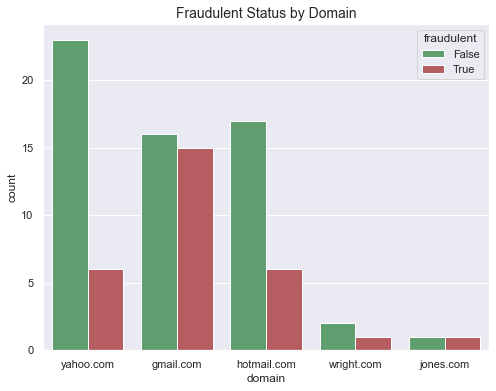

In [12]:
top_domains = data["domain"].value_counts().head().index.tolist()
create_countplot_with_hue(data[data["domain"].isin(top_domains)], "domain", order=None)

From 5 most frequent domains, gmail.com seems to be popular both from genuine customers and fraudsters.

I am going to take a closer look if those 85 domains are all valid.

In [13]:
data["valid_domain"] = data["domain"].apply(is_valid_domain)

In [14]:
data["valid_domain"].value_counts()

True     134
False    34 
Name: valid_domain, dtype: int64

34 domains are invalid.

In [15]:
data[data["valid_domain"] == False][
    ["fraudulent", "customerEmail", "domain"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerEmail,domain
6,1,samuel15@saunders-rhodes.com,saunders-rhodes.com
9,1,ubranch@rivera-parker.info,rivera-parker.info
12,0,christineklein@wright-boyd.org,wright-boyd.org
17,0,alec27@bell.com,bell.com
20,0,psantiago@nelson.net,nelson.net
21,0,harrisnicholas@mitchell-hancock.com,mitchell-hancock.com
25,0,karen54@mullins.biz,mullins.biz
32,1,9es7t@u6n7x,u6n7x
36,0,richard05@hanson-key.org,hanson-key.org
41,0,smithtiffany@davis-perkins.com,davis-perkins.com


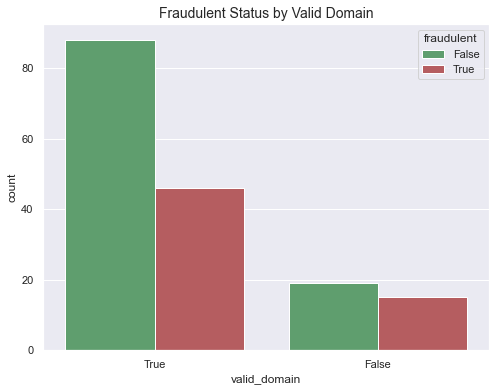

In [16]:
create_countplot_with_hue(data, "valid_domain", order=[True, False])


Almost half of customers who have invalid email domain are fraudsters. That might be a good indicator of beging fraudulent customer or not.

#### Analysis of the proper email prefixes (before '@')

In [17]:
pattern = r"^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$"

data["proper_prefix"] = data["customerEmail"].str.contains(pattern)

In [18]:
data["proper_prefix"].value_counts()

True     164
False    4  
Name: proper_prefix, dtype: int64

In [19]:
data[data["proper_prefix"] == False][["fraudulent", "customerEmail"]].style.apply(
    highlight_fraudulent_row, axis=1
)

,fraudulent,customerEmail
32,1,9es7t@u6n7x
62,1,hj8maoy@1jcfcxs7
108,1,3fooiar@6eph
151,1,1yf0@jedyz63t


All of the customers who have invalid email prefixes are fraudsters.

Further analysis of the emails might include:
* using external tools such as DomainTools that provides information on domain name ownership, registration history and associated IP addresses.
* using email reputation services such as Sender Score that checks emails based on factors such as volume of email sent or spam compliants.

----

### **Analysis of customers' phones**

I am going to take a look at 10 random rows from a database to check what can be the structure of the mobile phone number.

In [20]:
data[["customerPhone"]].sample(n=10, random_state=0)

,customerPhone
151,463-609-3475
56,266-228-3021x90360
123,1-333-131-2746x6449
60,698-954-1805
100,03898354581
51,791-857-3838x784
7,044-642-9860
5,+65(5)8997489788
86,257-706-1003x92053
135,+36(0)4967812825


It looks like a number should include the following pattern: 3-digits ./- 3-digits ./- 4digits. Sometimes it has additional number at the end and area code in the beggining. I will try to find phone numbers that seem to have anomalies.

In [21]:
pattern = r"^(\D*\d{3}[\.\-\(\)]?\D*\d{3}[\.\-\(\)]?\D*\d{4}\D*)$"
data["flag_anomalies_phone"] = data["customerPhone"].apply(
    lambda x: int(not bool(re.match(pattern, x)))
)

In [22]:
data[["customerPhone", "flag_anomalies_phone"]].sample(n=5, random_state=0)

,customerPhone,flag_anomalies_phone
151,463-609-3475,0
56,266-228-3021x90360,1
123,1-333-131-2746x6449,1
60,698-954-1805,0
100,03898354581,1


In [23]:
data["flag_anomalies_phone"].value_counts()

1    126
0    42 
Name: flag_anomalies_phone, dtype: int64

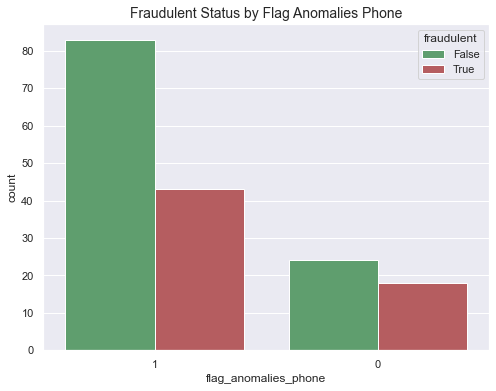

In [24]:
create_countplot_with_hue(data, "flag_anomalies_phone", [1, 0])


My analysis shows that almost all phone numbers (126 out of 168) have some sort of anomalies. Probably there should be more investigation performed to assess the phone numbers validity.

----

### **Analysis of IP addresses**

An IP address is considered proper if it follows the standard format of an IPv4 or IPv6 address. 

In [25]:
data["ip_type"] = data["customerIPAddress"].apply(lambda x: is_proper_ip(x))

In [26]:
data["ip_type"].value_counts()

global    162
local     6  
Name: ip_type, dtype: int64

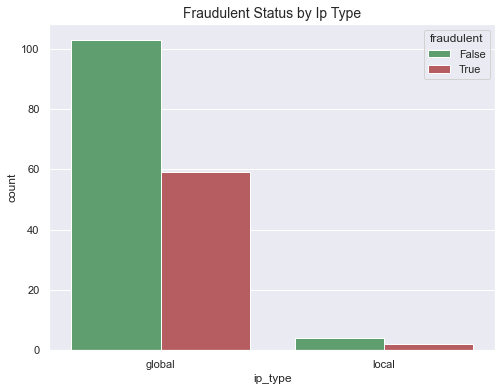

In [27]:
create_countplot_with_hue(data, "ip_type", order=None)


All IP addresses look to be valid, 162 are global IP addresses, 6 are local. Not visible trends in terms of being fraudster or not and IP types.

I am going to check IP localization. For doing so, I use geoip2 library.

In [28]:
database_path = "GeoLite2-Country.mmdb"

reader = geoip2.database.Reader(database_path)


def get_ip_localization(row):
    try:
        response = reader.country(row["customerIPAddress"])
        return response.country.name
    except geoip2.errors.AddressNotFoundError:
        return "not_found"


data["ip_localization"] = data.apply(get_ip_localization, axis=1)

In [29]:
data["ip_localization"].value_counts()

not_found         90
United States     32
China             7 
Japan             4 
United Kingdom    4 
Hong Kong         4 
Italy             3 
Germany           2 
South Korea       2 
Argentina         2 
Singapore         2 
Romania           2 
Canada            2 
Taiwan            2 
Morocco           1 
Iran              1 
Armenia           1 
France            1 
Chile             1 
Russia            1 
Vietnam           1 
Sweden            1 
South Africa      1 
Poland            1 
Name: ip_localization, dtype: int64

For 90 (more than a half) IP addresses localization was not possible (IP addresses did not appear in a database).

In [30]:
data["customerBillingAddress"].sample(n=5, random_state=0)


151    12350 Nicholas Greens\nLawsonborough, NC 70237-3962       
56     37549 Crawford Forest\nChristopherside, KY 96656          
123    PSC 1043, Box 1089\nAPO AA 29395-9131                     
60     1292 Tricia Key Suite 062\nMarthabury, KS 40445           
100    206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567
Name: customerBillingAddress, dtype: object

Addresses in the database looks like they are based in the US, so I am going to take a closer look on next more frequent localization: China, Japan and the UK.

In [31]:
data[data["ip_localization"] == "China"][
    ["fraudulent", "customerBillingAddress", "ip_localization"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerBillingAddress,ip_localization
0,0,"5493 Jones Islands Brownside, CA 51896",China
31,0,"87265 Woods Square Port Heidimouth, LA 03208-8304",China
45,1,"77711 Pamela Ridge New Kayla, IL 27182",China
49,0,"33328 Mendez Shore Apt. 328 North Miguelville, MT 05102-0874",China
106,0,"5154 Fernandez Points Apt. 712 Mcguirehaven, MN 91595",China
128,0,"9205 Jeremiah Field Suite 815 East Christopher, IA 93399",China
136,1,"265 Marisa Keys Lynchmouth, WV 63252-7526",China


In [32]:
data[data["ip_localization"] == "Japan"][
    ["fraudulent", "customerBillingAddress", "ip_localization"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerBillingAddress,ip_localization
1,1,"356 Elizabeth Inlet Suite 120 Port Joshuabury, NM 37681",Japan
21,0,"357 Barbara Crossroad Jacobsburgh, WY 09289-9170",Japan
113,0,"4608 Travis Spring Sarahtown, KS 65613",Japan
138,0,"16855 Lopez Tunnel Port Stephanieville, PW 58997-9470",Japan


In [33]:
data[data["ip_localization"] == "United Kingdom"][
    ["fraudulent", "customerBillingAddress", "ip_localization"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerBillingAddress,ip_localization
9,1,"6974 Robertson Common Apt. 902 Port Juanside, ID 80590-9633",United Kingdom
47,0,"6395 Christopher Lakes Suite 062 South Dana, ID 74510-4952",United Kingdom
59,0,"585 Veronica Loop Suite 856 East Rebeccachester, AZ 55756",United Kingdom
77,0,"9923 Williams Ramp East Lauraburgh, GA 48874",United Kingdom


----

### **Analysis of customers' Billing Addresses**

I am going to look if billing addresses of customers include 'box' and how it corresponds with being fraudulent or not.

In [34]:
data["billing_address_box"] = data["customerBillingAddress"].str.contains(
    "box", case=False, regex=True
)

In [35]:
data[["customerBillingAddress", "billing_address_box"]].sample(n=5, random_state=0)

,customerBillingAddress,billing_address_box
151,"12350 Nicholas Greens\nLawsonborough, NC 70237-3962",False
56,"37549 Crawford Forest\nChristopherside, KY 96656",False
123,"PSC 1043, Box 1089\nAPO AA 29395-9131",True
60,"1292 Tricia Key Suite 062\nMarthabury, KS 40445",False
100,"206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567",False


In [36]:
data["billing_address_box"].value_counts()

False    159
True     9  
Name: billing_address_box, dtype: int64

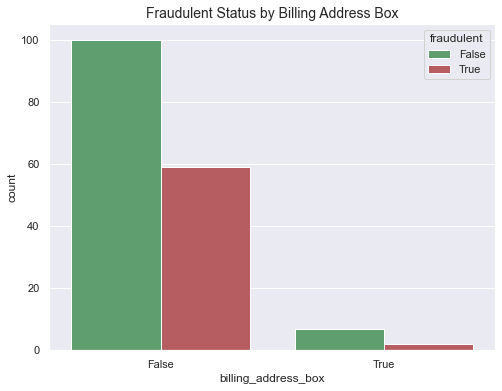

In [37]:
create_countplot_with_hue(data, "billing_address_box", order=None)

"box" in a billing address is not a good predictor for being a fraudulent customer or not.

Additionaly I am going to extract from billing addresses information about city, state and the zip code.

In [38]:
data[["billing_city", "billing_state", "billing_zip_code"]] = data[
    "customerBillingAddress"
].apply(lambda x: pd.Series(extract_address_info(x)))

In [39]:
data[
    ["customerBillingAddress", "billing_city", "billing_state", "billing_zip_code"]
].head()

,customerBillingAddress,billing_city,billing_state,billing_zip_code
0,"5493 Jones Islands\nBrownside, CA 51896",Brownside,CA,51896
1,"356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681",Port Joshuabury,NM,37681
2,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",Davisberg,PR,72250
3,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM 51359",Nortonstad,FM,51359
4,"148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871",Port Jenniferside,TN,60556-0871


In [40]:
data["billing_state"].nunique()

55

From state codes I could distinguish 55 unique values.

In [41]:
data["billing_state"].value_counts()[:6]

      13
MH    6 
MN    6 
IA    5 
IL    5 
SC    5 
Name: billing_state, dtype: int64

For 13 customers I failed extracting state information. Top 5 localizations are MH, MN, IA, IL and SC. All except MH look valid.

In [42]:
data[data["billing_state"] == ""][
    ["fraudulent", "customerBillingAddress", "billing_state"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerBillingAddress,billing_state
8,0,USNS Price FPO AE 14661,
27,0,Unit 0643 Box 8346 DPO AA 55632-6780,
42,0,USS Barr FPO AE 16052-3851,
67,0,USNV Bennett FPO AE 82607-5790,
71,0,Unit 0375 Box 6645 DPO AP 74311,
97,1,"PSC 9111, Box 9839 APO AA 57283-9646",
109,0,Unit 6251 Box 1562 DPO AP 54457-8709,
120,1,Unit 4843 Box 7401 DPO AP 92304-9120,
123,0,"PSC 1043, Box 1089 APO AA 29395-9131",
132,0,USNS Ramos FPO AE 16248,


According to https://secure.shipitapo.com/personal/apo_fpo_guide.php  APO and FPO are abbreviations used by the US Military Postal Service to deliver mail and packages to military personnel overseas. DPO stands for Diplomatic Post Office. 

Additionaly:
> AA = Armed Forces (the) Americas, 
> 
> AE = Armed Forces Europe, 
> 
> AP = Armed Forces Pacific.

In [43]:
data[data["billing_state"] == "MH"][
    ["fraudulent", "customerBillingAddress", "billing_state"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerBillingAddress,billing_state
16,0,"812 Moss Radial Suite 844 North Patriciaburgh, MH 13975",MH
29,1,"372 Michael Club Suite 553 Herrerafort, MH 52953",MH
57,1,"49680 Brian Squares Apt. 122 Port Walterburgh, MH 02766-0708",MH
80,1,"49680 Brian Squares Apt. 122 Port Walterburgh, MH 02766-0708",MH
90,1,"49680 Brian Squares Apt. 122 Port Walterburgh, MH 02766-0708",MH
153,1,"0008 Jessica Stream Mcbridetown, MH 04017",MH


It looks like state MH does not exist. 5 out of 6 customers using this state are fraudulent.

I am going to confirm if states exctracted from the 'customerBillingAddress' column are valid US states.

In [44]:
states = pd.read_csv("states.csv")
states.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [45]:
states.set_index("Abbreviation", inplace=True)


def get_state_name(state_abbrev):
    if state_abbrev in states.index:
        return states.loc[state_abbrev, "State"]
    else:
        return "not_present"


data["state_name"] = data["billing_state"].apply(get_state_name)

In [46]:
data["state_name"].value_counts()[:10]

not_present       37
Minnesota         6 
Oregon            5 
South Carolina    5 
Louisiana         5 
Illinois          5 
Iowa              5 
California        4 
Maine             4 
Idaho             4 
Name: state_name, dtype: int64

For 37 customers I failed matching corresponding state name. I am going to take a closer look into that.

In [47]:
data[data["state_name"] == "not_present"][
    ["fraudulent", "customerBillingAddress", "state_name", "billing_state"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerBillingAddress,state_name,billing_state
2,0,"8478 Sean Ridges Apt. 441 Davisberg, PR 72250",not_present,PR
3,0,"7769 Elizabeth Bridge Apt. 343 Nortonstad, FM 51359",not_present,FM
8,0,USNS Price FPO AE 14661,not_present,
16,0,"812 Moss Radial Suite 844 North Patriciaburgh, MH 13975",not_present,MH
23,1,"13553 Michelle Freeway Apt. 290 Tammyhaven, GU 02869-4630",not_present,GU
25,0,"526 Ronald Cliffs West Christinaville, GU 76418",not_present,GU
27,0,Unit 0643 Box 8346 DPO AA 55632-6780,not_present,
29,1,"372 Michael Club Suite 553 Herrerafort, MH 52953",not_present,MH
33,0,"437 Jean Well Andrewville, FM 13796",not_present,FM
39,0,"229 Michelle Union Suite 692 Lake Sarahport, AS 45607",not_present,AS


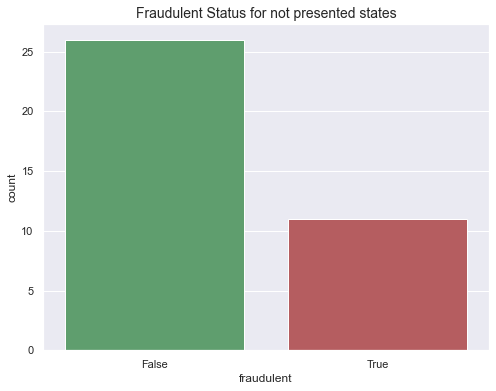

In [48]:
countplot_one_cat(
    data[data["state_name"] == "not_present"], "fraudulent", "not presented states"
)


In [49]:
data[data["billing_zip_code"] == ""][
    ["fraudulent", "customerBillingAddress"]
].style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,customerBillingAddress
8,0,USNS Price FPO AE 14661
27,0,Unit 0643 Box 8346 DPO AA 55632-6780
42,0,USS Barr FPO AE 16052-3851
67,0,USNV Bennett FPO AE 82607-5790
71,0,Unit 0375 Box 6645 DPO AP 74311
97,1,"PSC 9111, Box 9839 APO AA 57283-9646"
109,0,Unit 6251 Box 1562 DPO AP 54457-8709
120,1,Unit 4843 Box 7401 DPO AP 92304-9120
123,0,"PSC 1043, Box 1089 APO AA 29395-9131"
132,0,USNS Ramos FPO AE 16248


Zip codes failed to be extracted in the same customers whose billing addresses are of DPO/FPO/APO-type.

CUSTOMER DEVICE

In [50]:
data["customerDevice"].nunique()


168

In [51]:
data["customerDevice"].sample(n=5, random_state=0)


151    j3a0155srqw0yeqvbgps
56     7u2y3wsyj7ehzfao86md
123    21rpvi89b6uon3c3x8gc
60     znzp16ko7mtwjfxgrle4
100    3nl9r01aoqks8pn0m4hb
Name: customerDevice, dtype: object

I have not analyzed deeply `customerDevice` column except of checking unique values - these are 168 so these are unique identifiers for all the customers.

----
----

### **Analysis of the orders**

I am going to:


*   count the number of orders for each of the customers
* check what is the minimum value of order for each customer and what is the maximum value for each customer
* check if shipping addresses are the same or if the customer chooses different addresses for its orders



Before I perform the steps above, I am going to check if all customers have at least one order.

In [52]:
empty_mask = data["orders_orderId"].apply(lambda x: len(x) == 0)
empty_rows = data[empty_mask]
print(len(empty_rows))

27


27 customers do not have any orders.

In [53]:
data["number_of_orders"] = data["orders_orderId"].apply(lambda x: len(x))
data["min_order_amount"] = data["orders_orderAmount"].apply(
    lambda x: min(x, default=-5)
)
data["max_order_amount"] = data["orders_orderAmount"].apply(
    lambda x: max(x, default=600)
)

#### Number of orders

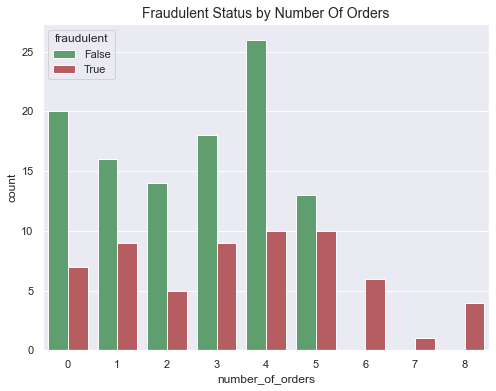

In [54]:
create_countplot_with_hue(data, "number_of_orders")


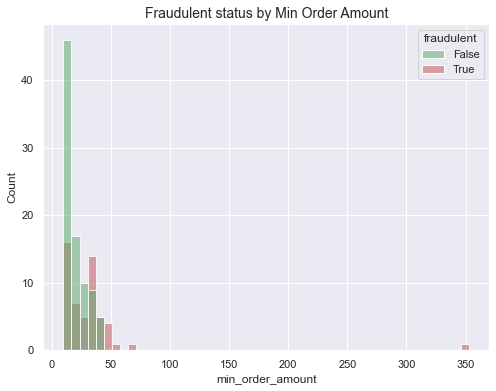

In [55]:
histplot_with_hue(data[data["min_order_amount"] > -1], "min_order_amount")

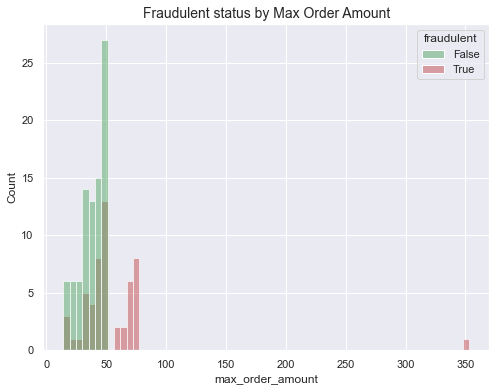

In [56]:
histplot_with_hue(data[data["max_order_amount"] < 400], "max_order_amount")

#### Order State

In [57]:
values_list = data["orders_orderState"].tolist()
unique_values = Counter([value for values in values_list for value in values])
print(unique_values)

Counter({'fulfilled': 400, 'failed': 50, 'pending': 28})


In [58]:
data["orders_orderState"].value_counts()[:10]

[]                                                         27
[fulfilled]                                                23
[fulfilled, fulfilled, fulfilled, fulfilled]               18
[fulfilled, fulfilled, fulfilled]                          17
[fulfilled, fulfilled, fulfilled, fulfilled, fulfilled]    10
[fulfilled, fulfilled]                                     10
[fulfilled, failed, fulfilled, fulfilled]                  5 
[failed, fulfilled, fulfilled]                             4 
[failed, fulfilled, fulfilled, fulfilled]                  3 
[failed, fulfilled]                                        3 
Name: orders_orderState, dtype: int64

I am going to check how fraudulent status differs for customers whose order status at least once were 'failed'.

In [59]:
data["failed_order"] = data["orders_orderState"].apply(
    lambda x: any(["failed" in s.lower() for s in x])
)


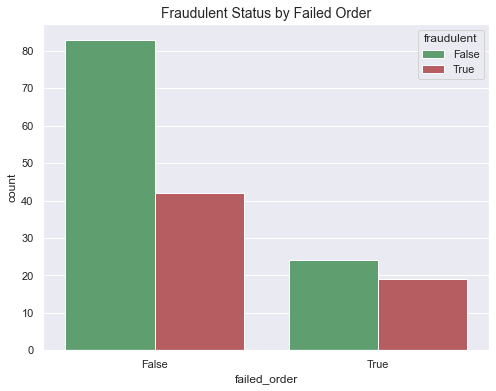

In [60]:
create_countplot_with_hue(data, "failed_order", order=None)


If customer's order status is failed, it might indicate that customer expose fraudulent behaviour.

#### Shipping Addresses

In [61]:
data["shipping_address_box"] = data["orders_orderShippingAddress"].apply(
    lambda x: any(["box" in s.lower() for s in x])
)

In [62]:
data[["orders_orderShippingAddress", "shipping_address_box"]].sample(
    n=5, random_state=0
)

,orders_orderShippingAddress,shipping_address_box
151,"[434 Joanne Shores\nWest Melissa, UT 85798-1374, PSC 7355, Box 0895\nAPO AE 05437, 12350 Nicholas Greens\nLawsonborough, NC 70237-3962, 12350 Nicholas Greens\nLawsonborough, NC 70237-3962, 12350 Nicholas Greens\nLawsonborough, NC 70237-3962]",True
56,"[58408 Stacy Grove\nPort Gregory, MD 11557-3871, 37549 Crawford Forest\nChristopherside, KY 96656, 37549 Crawford Forest\nChristopherside, KY 96656, 37549 Crawford Forest\nChristopherside, KY 96656, 37549 Crawford Forest\nChristopherside, KY 96656]",False
123,"[31997 Brooks Dam Apt. 491\nJensenfort, RI 68413, PSC 1043, Box 1089\nAPO AA 29395-9131]",True
60,"[702 Richard Dale Suite 484\nNew Paula, CT 56858-8909, 1292 Tricia Key Suite 062\nMarthabury, KS 40445, 1292 Tricia Key Suite 062\nMarthabury, KS 40445, 15587 Rios Center\nEast Dawn, AR 22196]",False
100,"[206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567, 206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567, 7193 James Circles\nTranport, NM 21037, 206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567]",False


In [63]:
data["shipping_address_box"].value_counts()

False    153
True     15 
Name: shipping_address_box, dtype: int64

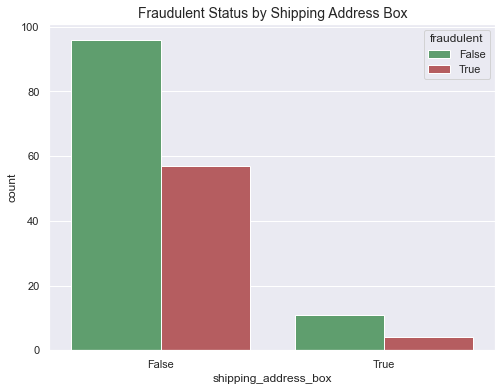

In [64]:
create_countplot_with_hue(data, "shipping_address_box", order=None)


Having 'box' in the shipping address does not means nothing particular for the analysis.

Shipping addresses might be multiple - I am going to check if billing address is one of the many.

In [65]:
data["billing_address_in_shipping_address"] = data.apply(
    is_billing_address_in_shipping_address, axis=1
)

In [66]:
data[
    [
        "customerBillingAddress",
        "orders_orderShippingAddress",
        "billing_address_in_shipping_address",
    ]
].sample(n=5, random_state=0)

,customerBillingAddress,orders_orderShippingAddress,billing_address_in_shipping_address
151,"12350 Nicholas Greens\nLawsonborough, NC 70237-3962","[434 Joanne Shores\nWest Melissa, UT 85798-1374, PSC 7355, Box 0895\nAPO AE 05437, 12350 Nicholas Greens\nLawsonborough, NC 70237-3962, 12350 Nicholas Greens\nLawsonborough, NC 70237-3962, 12350 Nicholas Greens\nLawsonborough, NC 70237-3962]",True
56,"37549 Crawford Forest\nChristopherside, KY 96656","[58408 Stacy Grove\nPort Gregory, MD 11557-3871, 37549 Crawford Forest\nChristopherside, KY 96656, 37549 Crawford Forest\nChristopherside, KY 96656, 37549 Crawford Forest\nChristopherside, KY 96656, 37549 Crawford Forest\nChristopherside, KY 96656]",True
123,"PSC 1043, Box 1089\nAPO AA 29395-9131","[31997 Brooks Dam Apt. 491\nJensenfort, RI 68413, PSC 1043, Box 1089\nAPO AA 29395-9131]",True
60,"1292 Tricia Key Suite 062\nMarthabury, KS 40445","[702 Richard Dale Suite 484\nNew Paula, CT 56858-8909, 1292 Tricia Key Suite 062\nMarthabury, KS 40445, 1292 Tricia Key Suite 062\nMarthabury, KS 40445, 15587 Rios Center\nEast Dawn, AR 22196]",True
100,"206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567","[206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567, 206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567, 7193 James Circles\nTranport, NM 21037, 206 Olson Viaduct Apt. 982\nNorth Charleschester, CA 67567]",True


In [67]:
data["billing_address_in_shipping_address"].value_counts()

True     127
False    41 
Name: billing_address_in_shipping_address, dtype: int64

In 41 cases billing address does not appear in the shipping address.

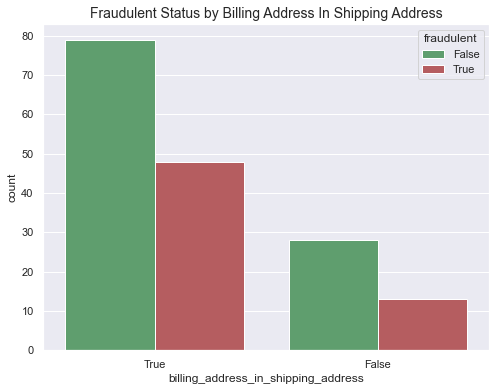

In [68]:
create_countplot_with_hue(
    data, "billing_address_in_shipping_address", order=[True, False]
)


From the graph is not clearly visible that this information means something for further modeling.

I am going to check if how many different shipping addresses each customer has.

In [69]:
data["distinct_shipping_addresses"] = data["orders_orderShippingAddress"].apply(
    lambda x: count_unique(x)
)

In [70]:
data[["orders_orderShippingAddress", "distinct_shipping_addresses"]].head()

,orders_orderShippingAddress,distinct_shipping_addresses
0,"[5493 Jones Islands\nBrownside, CA 51896, 5493 Jones Islands\nBrownside, CA 51896]",1
1,"[898 Henry Ports\nNew Keithview, CA 95893-2497, 356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681, 5093 Bryan Forks\nJoshuaton, FM 01565-9801]",3
2,"[8478 Sean Ridges Apt. 441\nDavisberg, PR 72250, 8478 Sean Ridges Apt. 441\nDavisberg, PR 72250, 22396 Victor Lights\nCarsonstad, MO 93914]",2
3,"[7769 Elizabeth Bridge Apt. 343\nNortonstad, FM 51359, 7769 Elizabeth Bridge Apt. 343\nNortonstad, FM 51359, 428 Ricardo Mountain\nPort Lorihaven, UT 07665-3981]",2
4,"[148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871, 148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871, 148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871, 620 Alexander Views\nMichaelstad, AK 94959-7484, 148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871, 148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871, 148 Russell Lodge Apt. 445\nPort Jenniferside, TN 60556-0871]",2


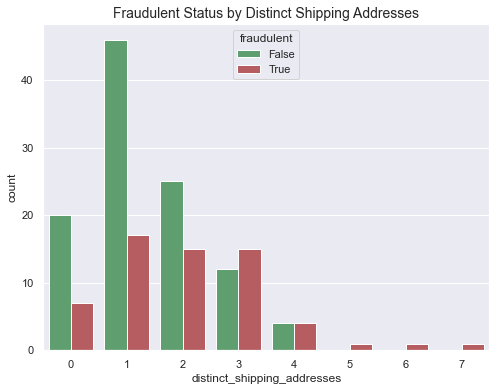

In [71]:
create_countplot_with_hue(data, "distinct_shipping_addresses", order=None)

It looks like the more shipping addresses a customer has, the more probable is that a customer is fraudulent.

----
----

### **Analysis od the payment methods**

#### Payment method types

Checking how many different payment types a customer has.

In [72]:
data["number_of_payment_methods"] = data["paymentMethods_paymentMethodType"].apply(
    lambda x: len(set(x))
)

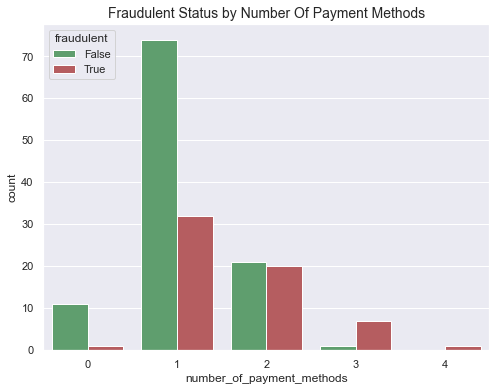

In [73]:
create_countplot_with_hue(data, "number_of_payment_methods", order=None)

The more payment method the customer has, the most likely is that this customer is fraudulent.

#### Payment failures

In [74]:
data["payments_failures"] = data[
    "paymentMethods_paymentMethodRegistrationFailure"
].apply(lambda x: any(x) if len(x) > 0 else False)

In [75]:
data[
    [
        "fraudulent",
        "paymentMethods_paymentMethodRegistrationFailure",
        "payments_failures",
    ]
].head().style.apply(highlight_fraudulent_row, axis=1)

,fraudulent,paymentMethods_paymentMethodRegistrationFailure,payments_failures
0,0,[True],1
1,1,"[True, False, False, False, False, False, False]",1
2,0,"[False, False]",0
3,0,[False],0
4,1,"[False, False, False, False, False, False]",0


In [76]:
data["payments_failures"].value_counts()

False    135
True     33 
Name: payments_failures, dtype: int64

33 customers have at least one payment failed.

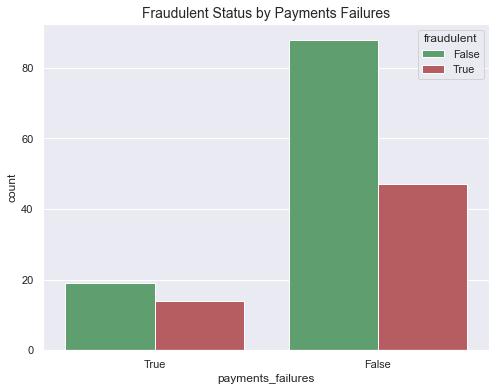

In [77]:
create_countplot_with_hue(data, "payments_failures", order=[True, False])

Having at least one of the payment method registration failure looks like promising indicator if a customer is fraudulent or not.

#### Number of payment providers

In [78]:
data["number_of_payment_providers"] = data[
    "paymentMethods_paymentMethodProvider"
].apply(lambda x: len(set(x)))

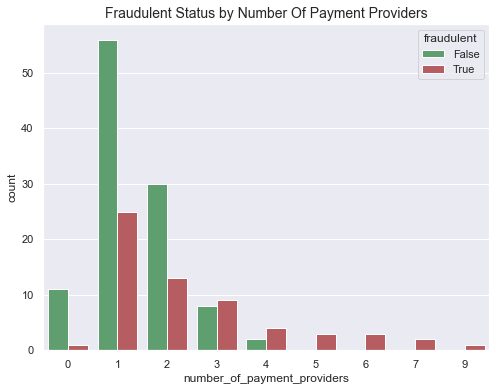

In [79]:
create_countplot_with_hue(data, "number_of_payment_providers", order=None)

The more payment providers a customer has, the more likely is that a custumer is a fraudster.

I am going to take a closer look to some of the payment method providers.

In [80]:
data["paymentMethods_paymentMethodProvider"].value_counts()[:10]

[VISA 16 digit]                  16
[JCB 16 digit]                   15
[]                               12
[Maestro]                        9 
[Mastercard]                     7 
[Discover]                       7 
[Voyager]                        6 
[JCB 15 digit]                   5 
[VISA 13 digit]                  5 
[Diners Club / Carte Blanche]    4 
Name: paymentMethods_paymentMethodProvider, dtype: int64

In [81]:
data[data["paymentMethods_paymentMethodProvider"].apply(lambda x: len(x) == 0)][
    [
        "fraudulent",
        "orders_orderId",
        "paymentMethods_paymentMethodId",
        "paymentMethods_paymentMethodProvider",
    ]
]

,fraudulent,orders_orderId,paymentMethods_paymentMethodId,paymentMethods_paymentMethodProvider
34,False,[],[],[]
38,False,[],[],[]
44,False,[],[],[]
47,False,[],[],[]
54,False,[],[],[]
70,False,[],[],[]
125,False,[],[],[]
133,True,[],[],[]
137,False,[],[],[]
139,False,[],[],[]


Payment methods are empty when no orders are made.

In [82]:
data[
    data["paymentMethods_paymentMethodProvider"].apply(
        lambda x: any("JCB 15 digit" in s for s in x)
    )
][["fraudulent", "paymentMethods_paymentMethodProvider"]].style.apply(
    highlight_fraudulent_row, axis=1
)

,fraudulent,paymentMethods_paymentMethodProvider
5,1,"['JCB 15 digit', 'VISA 16 digit']"
33,0,"['JCB 15 digit', 'JCB 15 digit', 'Maestro']"
42,0,['JCB 15 digit']
52,0,"['American Express', 'Maestro', 'JCB 15 digit']"
66,0,"['JCB 15 digit', 'JCB 16 digit', 'Discover']"
68,1,"['Mastercard', 'VISA 16 digit', 'JCB 15 digit', 'VISA 13 digit', 'Voyager', 'VISA 13 digit', 'Diners Club / Carte Blanche', 'VISA 13 digit', 'Diners Club / Carte Blanche', 'VISA 13 digit', 'VISA 16 digit', 'Maestro', 'Discover', 'JCB 16 digit', 'Diners Club / Carte Blanche']"
80,1,"['VISA 16 digit', 'VISA 16 digit', 'American Express', 'JCB 16 digit', 'Voyager', 'VISA 16 digit', 'Diners Club / Carte Blanche', 'VISA 13 digit', 'JCB 16 digit', 'JCB 15 digit', 'American Express', 'JCB 16 digit', 'VISA 16 digit', 'VISA 16 digit']"
84,1,['JCB 15 digit']
85,1,"['Discover', 'JCB 16 digit', 'JCB 16 digit', 'JCB 15 digit']"
92,0,['JCB 15 digit']


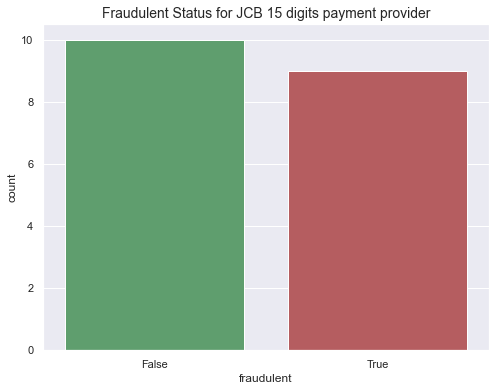

In [83]:
countplot_one_cat(
    data[
        data["paymentMethods_paymentMethodProvider"].apply(
            lambda x: any("JCB 15 digit" in s for s in x)
        )
    ],
    "fraudulent",
    "JCB 15 digits payment provider",
)


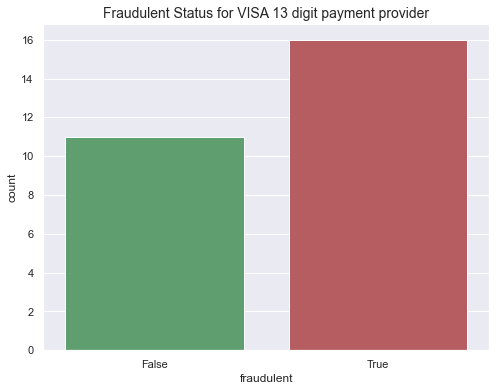

In [84]:
countplot_one_cat(
    data[
        data["paymentMethods_paymentMethodProvider"].apply(
            lambda x: any("VISA 13 digit" in s for s in x)
        )
    ],
    "fraudulent",
    "VISA 13 digit payment provider",
)


Using any of JCB 15 digit or VISA 13 digit payment method providers might have a significant impact if a customer is fraudulent or not.

#### Payment issuers

In [85]:
data["number_of_payment_issuers"] = data["paymentMethods_paymentMethodIssuer"].apply(
    lambda x: len(set(x))
)

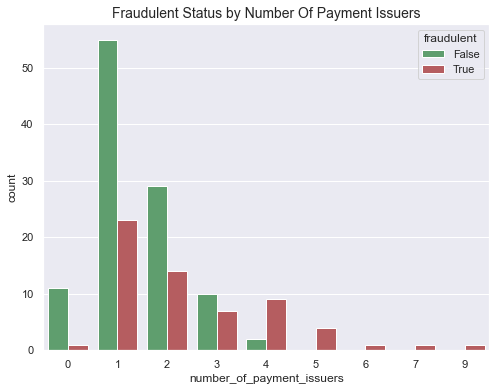

In [86]:
create_countplot_with_hue(data, "number_of_payment_issuers", order=None)

The more payment issuers a customer has, the more likely is that a customer is a fraudster.

In [87]:
data["paymentMethods_paymentMethodIssuer"].value_counts()[:10]

[Her Majesty Trust]           12
[]                            12
[Rose Bancshares]             12
[Grand Credit Corporation]    10
[Fountain Financial Inc.]     8 
[His Majesty Bank Corp.]      6 
[Bulwark Trust Corp.]         5 
[Solace Banks]                5 
[Citizens First Banks]        5 
[Vertex Bancorp]              4 
Name: paymentMethods_paymentMethodIssuer, dtype: int64

I am going to take a closer look for some of the issuers.

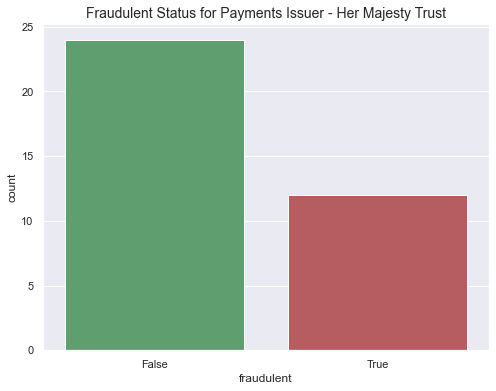

In [88]:
countplot_one_cat(
    data[
        data["paymentMethods_paymentMethodIssuer"].apply(
            lambda x: any("Her Majesty Trust" in s for s in x)
        )
    ],
    "fraudulent",
    "Payments Issuer - Her Majesty Trust",
)


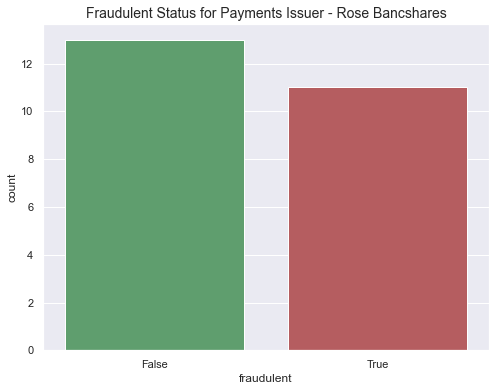

In [89]:
countplot_one_cat(
    data[
        data["paymentMethods_paymentMethodIssuer"].apply(
            lambda x: any("Rose Bancshares" in s for s in x)
        )
    ],
    "fraudulent",
    "Payments Issuer - Rose Bancshares",
)


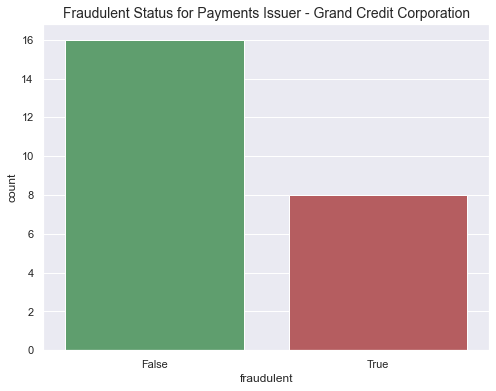

In [90]:
countplot_one_cat(
    data[
        data["paymentMethods_paymentMethodIssuer"].apply(
            lambda x: any("Grand Credit Corporation" in s for s in x)
        )
    ],
    "fraudulent",
    "Payments Issuer - Grand Credit Corporation",
)


Among those 3 most frequent issuers I would say that Rose Bancshares looks suspicious, but for others it is not so clearly visible.

----
----

### **Analysis of the transactions**

Health check if orderIDs from `orders` corresponds with ordersId from `transactions`.

In [91]:
data["same_orders"] = data.apply(
    lambda x: compare_lists(x["orders_orderId"], x["transactions_orderId"]), axis=1
)
data["same_orders"].value_counts()

True     89
False    79
Name: same_orders, dtype: int64

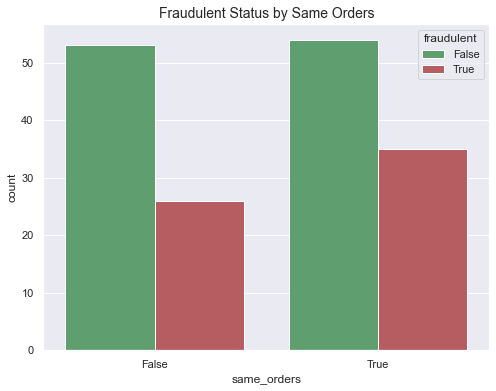

In [92]:
create_countplot_with_hue(data, "same_orders", order=None)

In [93]:
data["same_payment_id"] = data.apply(
    lambda x: compare_lists(
        x["paymentMethods_paymentMethodId"], x["transactions_paymentMethodId"]
    ),
    axis=1,
)
data["same_payment_id"].value_counts()

False    143
True     25 
Name: same_payment_id, dtype: int64

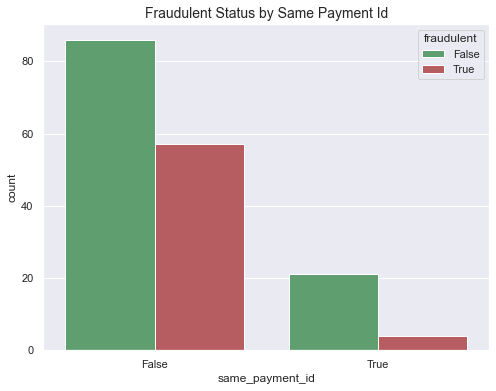

In [94]:
create_countplot_with_hue(data, "same_payment_id", order=None)

Payment Method Ids if fully corresponds between two columns, look like a good indicator that a customer is not a fraudster.

In [95]:
data[["paymentMethods_paymentMethodId", "transactions_paymentMethodId"]]

,paymentMethods_paymentMethodId,transactions_paymentMethodId
0,[wt07xm68b],"[wt07xm68b, wt07xm68b]"
1,"[y3xp697jx, 6krszxc05, 5z1szj2he, m52tx8e1s, 41ug157xz, 4dpg5sx2b, bcx9pa3wf]","[41ug157xz, 41ug157xz, y3xp697jx]"
2,"[8pneoi03z, dluy3jka0]","[8pneoi03z, 8pneoi03z, 8pneoi03z, dluy3jka0, 8pneoi03z]"
3,[pdxjdwui4],"[pdxjdwui4, pdxjdwui4, pdxjdwui4]"
4,"[w1i1zq3rg, 7o30osjpd, 76bw9eqg2, gehl28i8u, olr4zf09x, s6escw45g]","[olr4zf09x, gehl28i8u, gehl28i8u, 76bw9eqg2, s6escw45g, 76bw9eqg2, w1i1zq3rg]"
...,...,...
163,[x644o186l],"[x644o186l, x644o186l, x644o186l]"
164,"[wsy5c41nf, vmktpy2mv, usu93euvb]","[wsy5c41nf, usu93euvb, wsy5c41nf, usu93euvb, wsy5c41nf, vmktpy2mv]"
165,"[j3foo2l16, xpd7j7c5g]","[j3foo2l16, xpd7j7c5g, xpd7j7c5g, j3foo2l16]"
166,"[b3jl38c9g, kcg6rzgch, pj3k9zcc7, hx496w5tf, oycs53i0s, 1tmkeoxbm]","[kcg6rzgch, 1tmkeoxbm, oycs53i0s, pj3k9zcc7, 1tmkeoxbm, pj3k9zcc7, oycs53i0s, oycs53i0s]"


In [96]:
data["same_order_amount"] = data.apply(
    lambda x: compare_lists(
        x["orders_orderAmount"], x["transactions_transactionAmount"]
    ),
    axis=1,
)
data["same_order_amount"].value_counts()

True     89
False    79
Name: same_order_amount, dtype: int64

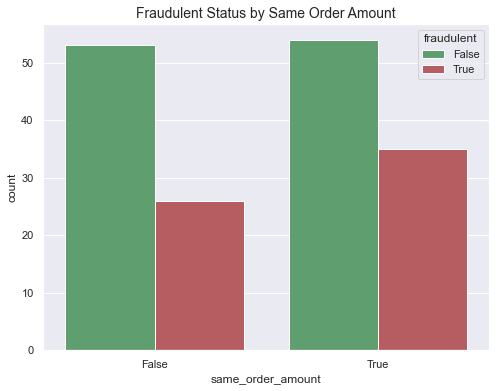

In [97]:
create_countplot_with_hue(data, "same_order_amount", order=None)

Corresponding columns derived from the original columns does not always reflect the same - the reason behind is that sometimes customer attemps transactions more times than make the order (even legitimate customers might have internet sessions disconnected and need to attemp payment for the second time)

In [98]:
data[["orders_orderAmount", "transactions_transactionAmount"]].sample(
    n=5, random_state=0
)


,orders_orderAmount,transactions_transactionAmount
151,"[38, 11, 45, 18, 12]","[38, 11, 45, 45, 18, 12, 12, 12, 12, 12]"
56,"[17, 24, 35, 32, 36]","[17, 24, 24, 35, 32, 36, 36, 36]"
123,"[43, 16]","[43, 16]"
60,"[31, 46, 16, 15]","[31, 46, 16, 15]"
100,"[41, 10, 38, 32]","[41, 10, 38, 38, 32, 32]"


#### Number of transactions

In [99]:
data["number_of_transactions"] = data["transactions_transactionAmount"].apply(
    lambda x: len(x)
)

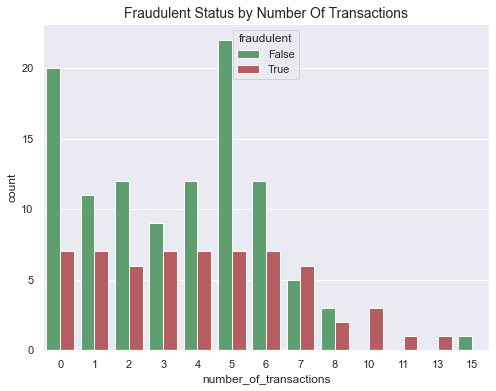

In [100]:
create_countplot_with_hue(data, "number_of_transactions", order=None)

I am going to calculate what is the ratio between number of transactions and the number of orders.

In [101]:
data["transactions_to_orders_ratio"] = np.where(
    data["number_of_transactions"] == 0,
    0,
    round((data["number_of_transactions"] / data["number_of_orders"]), 2),
)

In [102]:
data["transactions_to_orders_ratio"].value_counts()

1.00    62
0.00    27
1.25    18
1.50    10
2.00    10
1.20    10
1.67    6 
1.33    6 
1.40    5 
1.17    3 
2.50    2 
1.60    2 
2.67    1 
2.33    1 
1.75    1 
1.38    1 
1.62    1 
4.00    1 
5.00    1 
Name: transactions_to_orders_ratio, dtype: int64

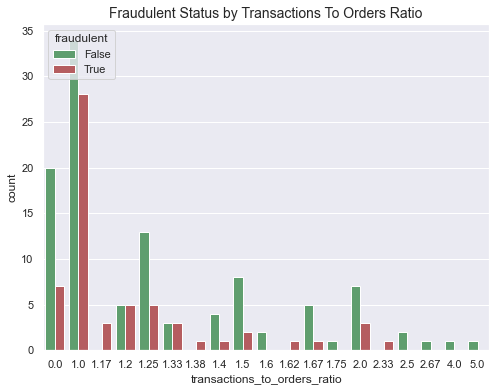

In [103]:
create_countplot_with_hue(data, "transactions_to_orders_ratio", order=None)

My suspicious was that if customer has more transactions than orders, it is more likely to be a fraudster, but apparentely it is not a case.

#### Failed transactions

In [104]:
data["failed_transactions"] = data["transactions_transactionFailed"].apply(
    lambda x: sum(x)
)

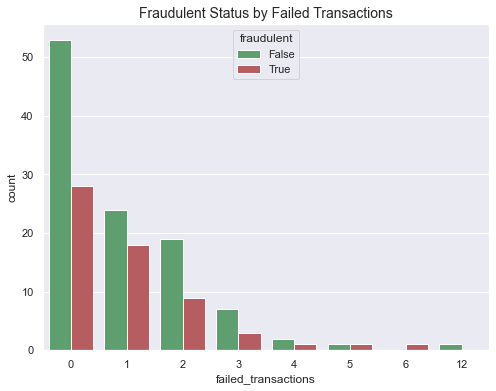

In [105]:
create_countplot_with_hue(data, "failed_transactions", order=None)

In [106]:
data.shape

(168, 48)

----
----

### **SUMMARY**

After thorough investigation, my analysis led to creation of 44 new columns. 

First modification included exctraction of a data from dictionaries present in all of the initial columns (15 features).

Further investigation led me to create additional features, like: valid email domains, number of transactions, number of payment methods, IP localizations and many more.

**Some of those features look promising in terms of predicting fraudulent transactions:**

> * domain: 
> 
> having a specific type of domain itself (gmail.com is quite popular among fraudsters; very unique domains might indicate fraudulent behaviour too)
> * valid_domain 
> 
> invalid format -> more likely to be fraudulent
> * proper_prefix 
> 
> if email has inproper prefix -> fraudulent behaviour
> * billing_state
> 
> valid US states are more likely to be common among legitimate customers
> * state_name 
>
> if not present -> more likely to be fraudulent
> * number_of_orders 
> 
> the highest number of orders -> more likely to be fraudulent
> * max_order_amount 
> 
> values distribution is higher for fraudulent customers than for legitimate
> * distinct_shipping_addresses 
> 
> more shipping addreses -> more likely to be fraudulent
> * number_of_payment_methods 
> 
> more payment methods -> more likely to be fraudulent
> * payment_failures 
> 
> if they happens -> more likely to be fraudulent
> * number_of_payment_providers 
> 
> more payment providers -> more likely to be fraudulent
> * same_payment_id 
> 
> if those correspond -> less likely to be fraudulent
> * number_of_transactions 
> 
> more transactions -> more likely to be fraudulent
> * failed_transactions 
> 
> if they appear -> more likely to be fraudulent

In [107]:
data.to_csv("modifided_data.csv")


### **MODELING**

For the modeling part I am going to use a dataframe that has additional features which I'd created in the EDA.

In [108]:
data = pd.read_csv(
    "modifided_data.csv",
)
data = data.drop(columns=["Unnamed: 0"], axis=1)
data.head(2)


,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,orders_orderId,orders_orderAmount,orders_orderState,orders_orderShippingAddress,...,number_of_payment_methods,payments_failures,number_of_payment_providers,number_of_payment_issuers,same_orders,same_payment_id,same_order_amount,number_of_transactions,transactions_to_orders_ratio,failed_transactions
0,False,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896","['vjbdvd', 'yp6x27']","[18, 26]","['pending', 'fulfilled']","['5493 Jones Islands\nBrownside, CA 51896', '5493 Jones Islands\nBrownside, CA 51896']",...,1,True,1,1,True,False,True,2,1.0,0
1,True,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,"356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681","['nlghpa', 'uw0eeb', 'bn44oh']","[45, 23, 43]","['fulfilled', 'fulfilled', 'fulfilled']","['898 Henry Ports\nNew Keithview, CA 95893-2497', '356 Elizabeth Inlet Suite 120\nPort Joshuabury, NM 37681', '5093 Bryan Forks\nJoshuaton, FM 01565-9801']",...,2,True,6,6,True,False,True,3,1.0,1


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 48 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   fraudulent                                       168 non-null    bool   
 1   customerEmail                                    168 non-null    object 
 2   customerPhone                                    168 non-null    object 
 3   customerDevice                                   168 non-null    object 
 4   customerIPAddress                                168 non-null    object 
 5   customerBillingAddress                           168 non-null    object 
 6   orders_orderId                                   168 non-null    object 
 7   orders_orderAmount                               168 non-null    object 
 8   orders_orderState                                168 non-null    object 
 9   orders_orderShippingAddress     

Modified dataframe has 48 columns, 11 of numeric types, 11 boolean types and 26 object-type. 

In [110]:
missing_cols = data.columns[data.isna().any()].tolist()
f"Columns with missing values: {missing_cols}"


"Columns with missing values: ['billing_state', 'billing_zip_code']"

In [111]:
missing_counts = data[missing_cols].isna().sum()
missing_counts

billing_state       13
billing_zip_code    13
dtype: int64

In two columns I have some missing values (which will be imputed in the preprocessing pipeline).

In [112]:
data[data.duplicated()]

,fraudulent,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,orders_orderId,orders_orderAmount,orders_orderState,orders_orderShippingAddress,...,number_of_payment_methods,payments_failures,number_of_payment_providers,number_of_payment_issuers,same_orders,same_payment_id,same_order_amount,number_of_transactions,transactions_to_orders_ratio,failed_transactions


I have no duplicates in a dataframe.

In [113]:
numeric_variable = data.select_dtypes(include=["float64", "int64"])


I am going to take a quick look if I have any anomalies present in numeric variable (I don't expect that because I monitored what feature I created).

In [114]:
numeric_variable.describe()

,flag_anomalies_phone,number_of_orders,min_order_amount,max_order_amount,distinct_shipping_addresses,number_of_payment_methods,number_of_payment_providers,number_of_payment_issuers,number_of_transactions,transactions_to_orders_ratio,failed_transactions
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.00000
mean,0.750000,2.845238,20.029762,133.922619,1.630952,1.285714,1.773810,1.791667,3.708333,1.112857,1.00000
std,0.434307,1.981919,29.682234,206.381050,1.240820,0.693363,1.417184,1.352993,2.801527,0.687736,1.45594
min,0.000000,0.000000,-5.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.750000,1.000000,11.000000,35.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000
50%,1.000000,3.000000,16.000000,46.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.00000
75%,1.000000,4.000000,30.000000,65.000000,2.000000,2.000000,2.000000,2.000000,5.000000,1.342500,2.00000
max,1.000000,8.000000,353.000000,600.000000,7.000000,4.000000,9.000000,9.000000,15.000000,5.000000,12.00000


To avoid dealing with the lists as values in the rows, I am going to use all the features that I have created into modeling (for every column except 'paymentMethods_paymentMethodId' I have created a feature that correspond with the information from the initial column but has easier input for further analysis.). I'm going to add a column for 'paymentMethods_paymentMethodId' that count payments IDs and two more columns for issuers.

In [115]:
data["number_of_payments"] = data["paymentMethods_paymentMethodId"].apply(
    lambda x: len(x.strip("[]").split(", "))
)


In [116]:
data[["paymentMethods_paymentMethodId", "number_of_payments"]].head()


,paymentMethods_paymentMethodId,number_of_payments
0,['wt07xm68b'],1
1,"['y3xp697jx', '6krszxc05', '5z1szj2he', 'm52tx8e1s', '41ug157xz', '4dpg5sx2b', 'bcx9pa3wf']",7
2,"['8pneoi03z', 'dluy3jka0']",2
3,['pdxjdwui4'],1
4,"['w1i1zq3rg', '7o30osjpd', '76bw9eqg2', 'gehl28i8u', 'olr4zf09x', 's6escw45g']",6


Adding column that indicates if one od the customer payment method providers was JCB 15 digit or VISA 13 digit. (That comes from the EDA - those providers might have positive impact for fraud detection).

In [117]:
data["flag_visa13"] = data["paymentMethods_paymentMethodProvider"].apply(
    lambda x: "VISA 13 digit" in x
)


In [118]:
data["flag_jcb15"] = data["paymentMethods_paymentMethodProvider"].apply(
    lambda x: "JCB 15 digit" in x
)


I am choosing all columns for modeling except 'orders_orderId', 'orders_orderAmount', 'orders_orderState', 'orders_orderShippingAddress', 'paymentMethods_paymentMethodId','paymentMethods_paymentMethodRegistrationFailure', 'paymentMethods_paymentMethodType', 'paymentMethods_paymentMethodProvider', 'paymentMethods_paymentMethodIssuer', 'transactions_transactionId','transactions_orderId', 'transactions_paymentMethodId', 'transactions_transactionAmount', 'transactions_transactionFailed'.

In [119]:
limited_data = data[
    [
        "fraudulent",
        "customerEmail",
        "customerPhone",
        "customerDevice",
        "customerIPAddress",
        "domain",
        "valid_domain",
        "proper_prefix",
        "flag_anomalies_phone",
        "ip_type",
        "ip_localization",
        "billing_address_box",
        "billing_city",
        "billing_state",
        "billing_zip_code",
        "state_name",
        "number_of_orders",
        "min_order_amount",
        "max_order_amount",
        "failed_order",
        "shipping_address_box",
        "billing_address_in_shipping_address",
        "distinct_shipping_addresses",
        "number_of_payment_methods",
        "payments_failures",
        "number_of_payment_providers",
        "number_of_payment_issuers",
        "same_orders",
        "same_payment_id",
        "same_order_amount",
        "number_of_transactions",
        "transactions_to_orders_ratio",
        "failed_transactions",
        "number_of_payments",
        "flag_visa13",
        "flag_jcb15",
    ]
]


In [120]:
limited_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   fraudulent                           168 non-null    bool   
 1   customerEmail                        168 non-null    object 
 2   customerPhone                        168 non-null    object 
 3   customerDevice                       168 non-null    object 
 4   customerIPAddress                    168 non-null    object 
 5   domain                               168 non-null    object 
 6   valid_domain                         168 non-null    bool   
 7   proper_prefix                        168 non-null    bool   
 8   flag_anomalies_phone                 168 non-null    int64  
 9   ip_type                              168 non-null    object 
 10  ip_localization                      168 non-null    object 
 11  billing_address_box             

I am going to change boolean type values to string objects.

In [121]:
bool_types = limited_data.select_dtypes(include=["bool"])

limited_data.loc[:, bool_types.columns] = limited_data.loc[
    :, bool_types.columns
].astype(str)


Checking the correlation between numerical variables.

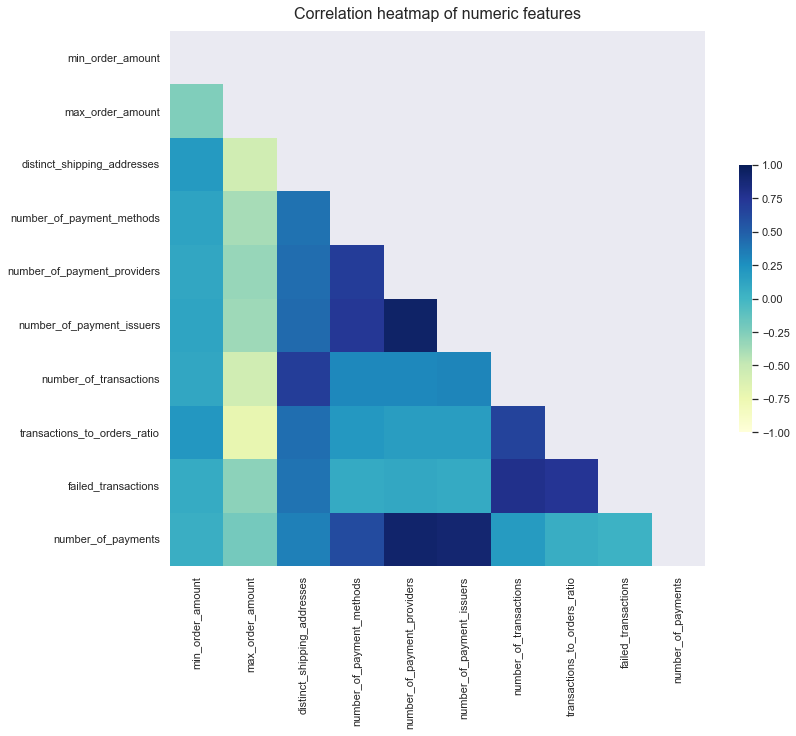

In [122]:
create_heatmap(
    limited_data.select_dtypes(exclude=["object"]), "numeric features", (12, 10)
)


Some features are highly correlated (both positively and negatively) so I am going to take care of that during preprocessing.

#### PREPARING DATASET FOR MODELLING

In [123]:
X = limited_data.drop(labels="fraudulent", axis=1)
y = limited_data["fraudulent"].replace({"False": 0, "True": 1})

num_pipeline = Pipeline(
    [
        ("drop_constant", DropConstantFeatures(tol=0.9, missing_values="ignore")),
        ("smart_corr", SmartCorrelatedSelection(method="pearson", threshold=0.8)),
        ("winsorizer", Winsorizer(tail="both", missing_values="ignore")),
        ("std_scaler", StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    [
        ("imputer", CategoricalImputer(fill_value="unknown")),
        ("encoder", CatBoostEncoder()),
    ]
)

num_features = X.select_dtypes(exclude=["object"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessing_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
    ],
    remainder="passthrough",
)


#### SPLITTING DATASET

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

X_train = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test = preprocessing_pipeline.transform(X_test)

For assesing if the models perform well or not I'm choosing to track normalized confusion matrix (that shows recall for both classes). I am also checking ROC_AUC score.

#### LOGISTIC REGRESSION

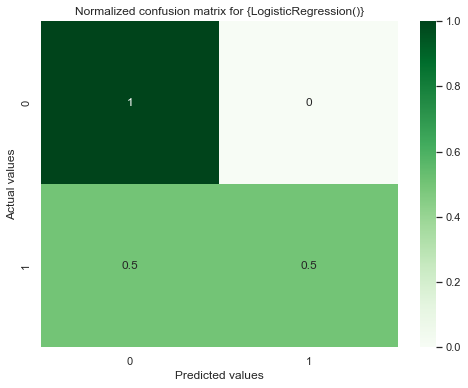

In [125]:
model = build_model(LogisticRegression(), X_train, y_train, X_test, y_test)

In [126]:
pred_proba_df = pd.DataFrame(model.predict_proba(X_test))
threshold_list = [
    0.3,
    0.4,
    0.45,
    0.5,
    0.55,
    0.6,
    0.7,
    0.8,
]
for i in threshold_list:
    print("\n******** For i = {} ******".format(i))
    y_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0)
    roc_auc = roc_auc_score(
        y_test.to_numpy().reshape(y_test.to_numpy().size, 1),
        y_pred.iloc[:, 1].to_numpy().reshape(y_pred.iloc[:, 1].to_numpy().size, 1),
    )
    print("ROC-AUC score: {}".format(round(roc_auc, 2)))

    print(
        confusion_matrix(
            y_test.to_numpy().reshape(y_test.to_numpy().size, 1),
            y_pred.iloc[:, 1].to_numpy().reshape(y_pred.iloc[:, 1].to_numpy().size, 1),
        )
    )



******** For i = 0.3 ******
ROC-AUC score: 0.64
[[17  5]
 [ 6  6]]

******** For i = 0.4 ******
ROC-AUC score: 0.73
[[21  1]
 [ 6  6]]

******** For i = 0.45 ******
ROC-AUC score: 0.73
[[21  1]
 [ 6  6]]

******** For i = 0.5 ******
ROC-AUC score: 0.75
[[22  0]
 [ 6  6]]

******** For i = 0.55 ******
ROC-AUC score: 0.71
[[22  0]
 [ 7  5]]

******** For i = 0.6 ******
ROC-AUC score: 0.71
[[22  0]
 [ 7  5]]

******** For i = 0.7 ******
ROC-AUC score: 0.71
[[22  0]
 [ 7  5]]

******** For i = 0.8 ******
ROC-AUC score: 0.62
[[22  0]
 [ 9  3]]


**Best ROC_AUC = 0.75.**

#### SUPPORT VECTOR MACHINES

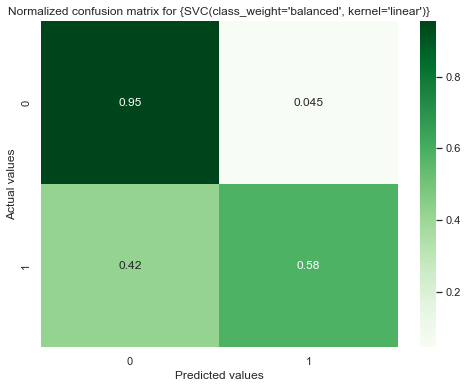

In [127]:
model = build_model(
    SVC(kernel="linear", class_weight="balanced"), X_train, y_train, X_test, y_test
)


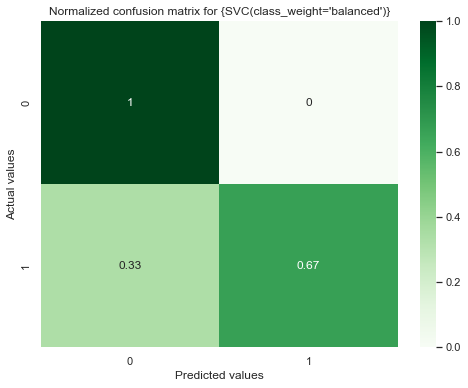

In [128]:
model = build_model(
    SVC(kernel="rbf", class_weight="balanced"), X_train, y_train, X_test, y_test
)


In [129]:
C = [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
kernel = ["rbf", "linear"]
params = {"kernel": kernel, "C": C, "gamma": gamma}
gd = GridSearchCV(
    estimator=SVC(class_weight="balanced"),
    param_grid=params,
    verbose=True,
)
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_params_)

Fitting 5 folds for each of 286 candidates, totalling 1430 fits
0.7393162393162394
{'C': 0.9, 'gamma': 0.1, 'kernel': 'rbf'}


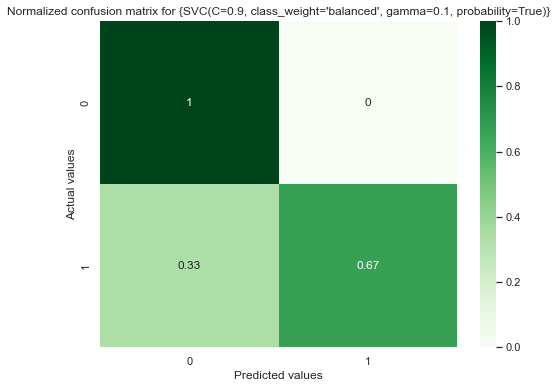

In [130]:
model = build_model(
    SVC(**gd.best_params_, class_weight="balanced", probability=True),
    X_train,
    y_train,
    X_test,
    y_test,
)

In [131]:
y_predict_proba = model.predict_proba(X_test)
roc_auc_score(y_test, y_predict_proba[:, 1])


0.8484848484848485

**Best ROC_AUC = 0.85.**

#### RANDOM FOREST

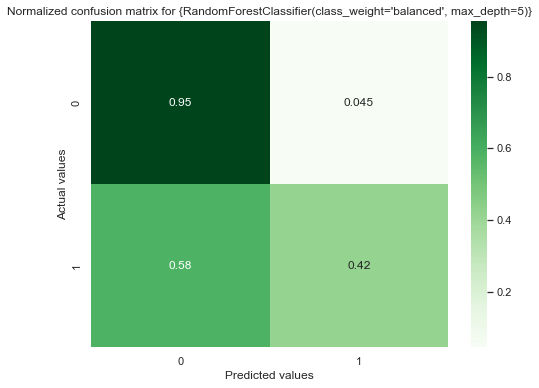

In [132]:
model = build_model(
    RandomForestClassifier(max_depth=5, class_weight="balanced"),
    X_train,
    y_train,
    X_test,
    y_test,
)


In [133]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=10)]
max_depth = [int(x) for x in np.linspace(2, 50, num=5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced"),
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc",
)
rf_random.fit(X_train, y_train)
f"Best params: {rf_random.best_params_}"
f"Best score: {rf_random.best_score_}"

'Best score: 0.7590206341157152'

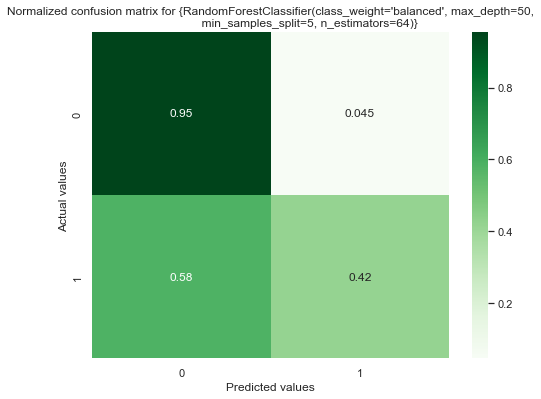

In [134]:
model = build_model(
    RandomForestClassifier(class_weight="balanced", **rf_random.best_params_),
    X_train,
    y_train,
    X_test,
    y_test,
)

**Best ROC_AUC = 0.77.**

### XGBOOST

In [135]:
counter = Counter(y)
estimate = counter[0] / counter[1]
print("Estimate: %.3f" % estimate)

Estimate: 1.754


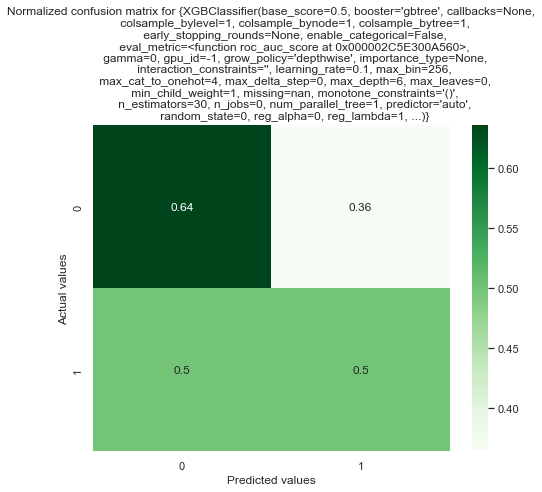

In [136]:
model = build_model(
    xg.XGBClassifier(
        objective="binary:logistic",
        n_estimators=30,
        learning_rate=0.1,
        eval_metric=roc_auc_score,
        scale_pos_weight=1.754,
    ),
    X_train,
    y_train,
    X_test,
    y_test,
)


In [137]:
param_distributions = {
    "max_depth": [3, 5, 6, 7, 8, 10, 15, 20],
    "base_score": [0.3, 0.4, 0.5, 0.6, 0.7],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "n_estimators": [30, 50, 100, 120, 200, 500],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

rs = RandomizedSearchCV(
    xg.XGBClassifier(objective="binary:logistic", scale_pos_weight=1.754),
    param_distributions=param_distributions,
    n_iter=300,
    cv=3,
    n_jobs=-1,
    scoring="roc_auc",
    random_state=42,
)
rs.fit(X_train, y_train)
rs.best_score_


0.7467234738723075

**Best ROC_AUC = 0.75.**

----
----

### BEST PERFORMING MODEL 

**SVC(gd.best_params_, class_weight='balanced', probability=True)**

gd.best_params_: {'C': 0.9, 'gamma': 0.1, 'kernel': 'rbf'}

Model achieved **ROC_AUC score = 0.85.**

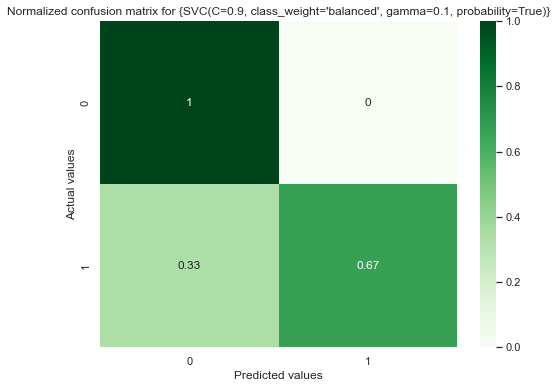

In [138]:
model = build_model(
    SVC(**gd.best_params_, class_weight="balanced", probability=True),
    X_train,
    y_train,
    X_test,
    y_test,
)

In [139]:
pred = model.predict(X_test)
cr = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(cr).T.style.background_gradient(cmap="Blues")
display(df)


,precision,recall,f1-score,support
0,0.846154,1.000000,0.916667,22.000000
1,1.000000,0.666667,0.800000,12.000000
accuracy,0.882353,0.882353,0.882353,0.882353
macro avg,0.923077,0.833333,0.858333,34.000000
weighted avg,0.900452,0.882353,0.875490,34.000000


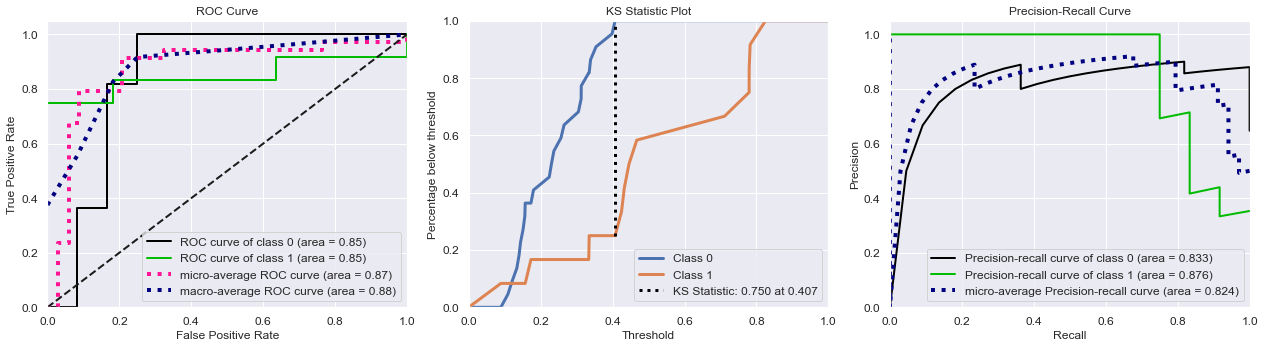

In [140]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

skplt.metrics.plot_roc_curve(y_test, y_predict_proba, ax=axs[0])
axs[0].set_title("ROC Curve")

skplt.metrics.plot_ks_statistic(y_test, y_predict_proba, ax=axs[1])
axs[1].set_title("KS Statistic Plot")

skplt.metrics.plot_precision_recall(y_test, y_predict_proba, ax=axs[2])
axs[2].set_title("Precision-Recall Curve")

plt.tight_layout()
plt.show()


**ROC Curve** plots the true positive rate against the false positive rates for different probability tresholds - so it means how model is able to distinguish classes when the probability treshold varies. We aim for TPR = 1 and FPR = 0, but in practice it is impossible to achieve, so the goal is to maxizime TPR while lowering the FPR. The curve should appear close to the left upper corner. In case of numerical representation, we aim to achieve ROC_AUC score (area under the curve) close to 0. In case of best SVC, it achieves 0.85.

**KS Statistic Plot** plots cumulative distribution functions of the predicted probabilities for both classes separately. In practice - it also shows how well model is able to distinguish classes. KS statistic ranges between 0 and 1, and the higher the statistic is, the better model behaves. In case of my best performing model, the score achieves 0.75 for the optimal treshold probability = 0.4.

**Precision-Recall Curve** plots precision and recall metrics for different probability treshold. Similarily it is possible to measure are under the curve as a single metric for evaluation of model performance, and it may range from 0 to 1. In case of my model, the score for positive class (fraudulent transaction) is equal to 0.83.



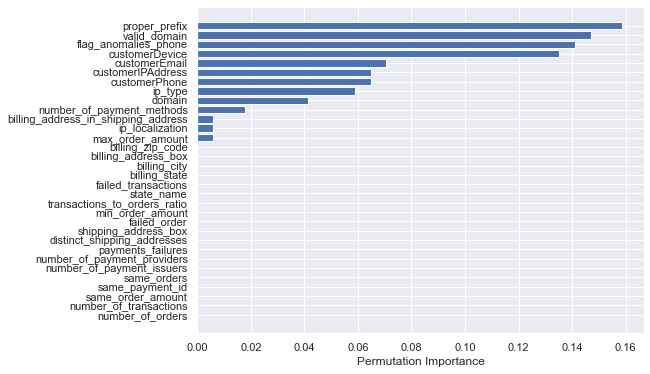

In [141]:
perm_importance = permutation_importance(model, X_test, y_test)
feature_names = limited_data.iloc[:, 1:].columns
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Permutation importance works by randomly shuffling the values of each feature and measuring the resulting decrease in model performance. In my case top 3 most influencing model peformance features are 'proper_prefix', 'valid_domain' and 'flag_anomalies_phone' so it mostly focuses on customer features itself (not their orders/payment methods/transactions). One of the feature 'biling state' has negative permutation importance value and that means it could be removed - it has negative impact on the model performance.

Using 134 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/34 [00:00<?, ?it/s]

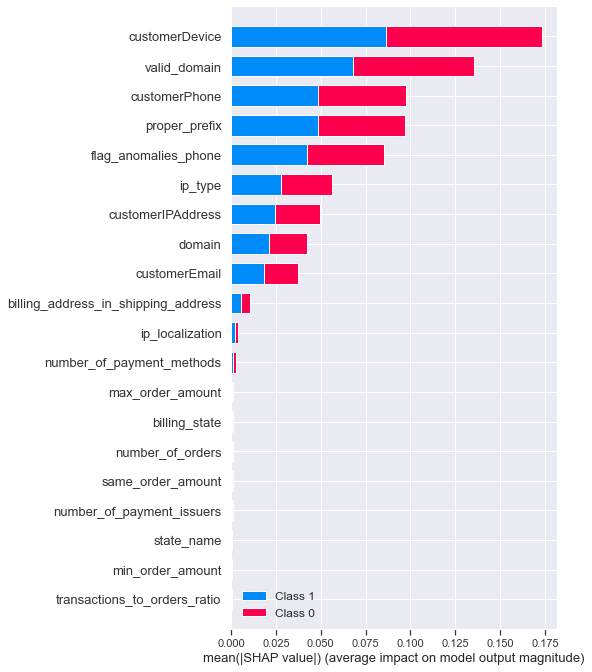

In [142]:
explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
feature_names = limited_data.iloc[:, 1:].columns
shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names)

The SHAP value for a feature is calculated by comparing the model's prediction with and without that feature included, while taking into account the interactions between features. Features with the highest values contribute the most to the model's prediction. Top 3 features are: customerDevice, valid_domain and customerPhone (similar as with the permutation importance (expected outcome, just two different methods)).



Quick recalculation of the model using top 12 features.

In [143]:
X = limited_data[
    [
        "customerEmail",
        "customerPhone",
        "customerDevice",
        "customerIPAddress",
        "domain",
        "valid_domain",
        "proper_prefix",
        "flag_anomalies_phone",
        "ip_type",
        "ip_localization",
        "billing_address_in_shipping_address",
        "number_of_payment_methods",
    ]
]
y = limited_data["fraudulent"].replace({"False": 0, "True": 1})

num_pipeline = Pipeline(
    [
        ("drop_constant", DropConstantFeatures(tol=0.9, missing_values="ignore")),
        ("smart_corr", SmartCorrelatedSelection(method="pearson", threshold=0.8)),
        ("winsorizer", Winsorizer(tail="both", missing_values="ignore")),
        ("std_scaler", StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    [
        ("imputer", CategoricalImputer(fill_value="unknown")),
        ("encoder", CatBoostEncoder()),
    ]
)

num_features = X.select_dtypes(exclude=["object"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessing_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features),
    ],
    remainder="passthrough",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

X_train = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test = preprocessing_pipeline.transform(X_test)

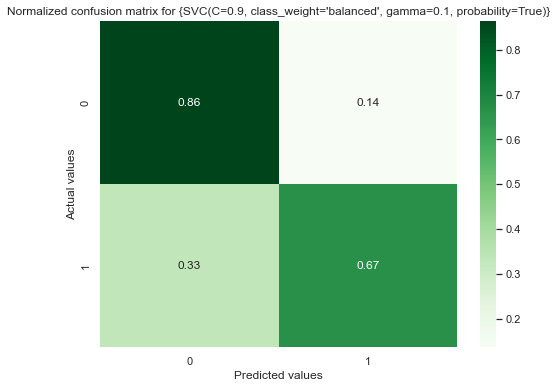

In [144]:
model = build_model(
    SVC(**gd.best_params_, class_weight="balanced", probability=True),
    X_train,
    y_train,
    X_test,
    y_test,
)

With just 12 out of 35 features that initially were fed into the model, SVC could predict positive class with the same success but it had worse scores for negative class.

SVC might be too complex model for so little number of rows (examples of customers). However, taking into account both theoretical measures and business consideration (we do not want legitimate customers to be classified as fraudsters because that might discourage them from further purchases and also cause black PR) and we do not also want to loss our money from non-detected fraudsters, I will treat my final model as good trade-off between complexity of the model/number of data points/final results.

In this analysis, I performed fraud detection classification using various machine learning models. Before modeling, I conducted exploratory data analysis (EDA) and engineered custom features to enhance the performance of the models. I achieved an ROC score of 0.85, indicating a relatively high level of predictive accuracy. Overall, the combination of EDA, feature engineering, and various classification models allowed for the effective identification of fraudulent transactions.

----
----

MORE IDEAS FOR IMPROVING ANALYSIS:

If I have more time to work on the project, I would:
*  focus more on tree-based models, especially gradient-boosted models
*  calculate possible loss in case of non-predicted chargebacks (taking into acount false negatives example order amounts and the fact that 1$ of chargeback cost merchants additional ~3$ (numbers are taken from Ravelin Blog Posts))
*  I would look for external sources and methods for analyzing customers devices (it has the biggest impact on models prediction while I couldn't spot any trends while doing EDA)
*  I would try to maybe add some features like - distance between IP localization and the billing/shipping address.
*  I would deploy model on GCP and calculate time for response.

----
----